In [1]:
import pandas as pd
from pandasql import sqldf
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt

## Loading Data

In [2]:
df=pd.read_csv("titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Engineer Features

In [3]:
#Convert categorical variable into numeric
df=sqldf("""
select
Survived as survived
, Pclass as pclass
,(case when Sex='female' then 1 else 2 end) as gender_num
,(case when Name like '%Mrs.%' then 1
      when Name like '%Miss.%' then 2
      when Name like '%Master.%' then 3
      when Name like '%Mr.%' then 4
      else 5
      end) as title_num
, (case when SibSp>0 then 1 else 2 end) as sibsp_num
, (case when Parch>0 then 1 else 2 end) as parch_num
from df
""")

df

,survived,pclass,gender_num,title_num,sibsp_num,parch_num
0,0,3,2,4,1,2
1,1,1,1,1,1,2
2,1,3,1,2,2,2
3,1,1,1,1,1,2
4,0,3,2,4,2,2
...,...,...,...,...,...,...
886,0,2,2,5,2,2
887,1,1,1,2,2,2
888,0,3,1,2,1,1
889,1,1,2,4,2,2


In [4]:
x_train, x_test, y_train, y_test = train_test_split(df[['pclass','title_num','sibsp_num','parch_num']],df['survived'],
                                                    test_size=0.2,random_state=2022)

print(x_train.shape)
print(x_test.shape)

(712, 4)
(179, 4)


In [5]:
#model=RandomForestClassifier(max_depth=5, n_estimators=100, min_samples_split=2,max_leaf_nodes=5)
model=xgb(learning_rate=0.1,n_estimators=1000,max_depth=3,gamma=1,seed=1234, use_label_encoder=False)
model.fit(x_train,y_train)

[17:47:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1234,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [6]:
#ROC / AUC
insample_pred=model.predict_proba(x_train)[:,1]
oot_pred=model.predict_proba(x_test)[:,1]

roc_score_insample=metrics.roc_auc_score(y_train,insample_pred)
roc_score_oot=metrics.roc_auc_score(y_test,oot_pred)

print("AR for In Sample is: ",2*roc_score_insample-1)
print("AR for OOT is: ",2*roc_score_oot-1)

AR for In Sample is:  0.7304286484916389
AR for OOT is:  0.739676113360324


In [7]:
#Roc Curve
fpr_t, tpr_t, thresholds_t = metrics.roc_curve(y_train,insample_pred)
fpr_v, tpr_v, thresholds_v = metrics.roc_curve(y_test,oot_pred)

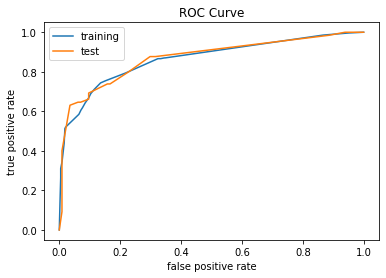

In [8]:
plt.plot(fpr_t,tpr_t, label='training')
plt.plot(fpr_v, tpr_v,label='test')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Save as pickle file

In [9]:
import pickle

filename = 'xgb_titanic_model.sav'
pickle.dump(model, open(filename, 'wb'))

## Analysing score band

In [10]:
#y_train,insample_pred
df_score=pd.DataFrame()
df_score['survived']=y_train
df_score['pred_probability']=insample_pred
df_score['pclass']=x_train['pclass']
df_score['title_num']=x_train['title_num']
df_score['sibsp_num']=x_train['sibsp_num']
df_score['parch_num']=x_train['parch_num']
df_score

,survived,pred_probability,pclass,title_num,sibsp_num,parch_num
660,1,0.504048,1,5,1,2
392,0,0.123959,3,4,1,2
135,0,0.130066,2,4,2,2
58,1,0.894781,2,2,1,1
127,1,0.130066,3,4,2,2
...,...,...,...,...,...,...
240,0,0.449462,3,2,1,2
689,1,0.937294,1,2,2,1
624,0,0.130066,3,4,2,2
173,0,0.130066,3,4,2,2


<AxesSubplot:ylabel='Frequency'>

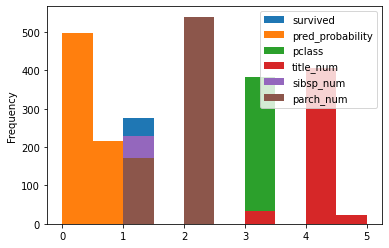

In [11]:
df_score.plot.hist("pred_probability")

In [12]:
df_score=sqldf("""
select*,
case when pred_probability<=0.13 then 5
     when pred_probability>0.13 and pred_probability<=0.30 then 4
     when pred_probability>0.30 and pred_probability<=0.48 then 3
     when pred_probability>0.48 and pred_probability<=0.91 then 2
     else 1
     end as score_band
from df_score  
     
     
""")

In [13]:
sqldf("""
select score_band,
sum(survived) as total_survived,
count(survived) as total_passengers,
max(pred_probability) as max_prob,
min(pred_probability) as min_prob,
sum(survived)*1.0/count(survived) as survival_rate
from df_score
group by score_band

""")

,score_band,total_survived,total_passengers,max_prob,min_prob,survival_rate
0,1,86,88,0.939840,0.910645,0.977273
1,2,92,127,0.902520,0.500912,0.724409
2,3,62,166,0.459341,0.336412,0.373494
3,4,33,269,0.156164,0.130066,0.122677
4,5,4,62,0.123959,0.115018,0.064516


## Function to manage prediction pipeline

In [14]:
def titanic_pipe(pclass,title,sibsp,parch):
    
    if title=='Mrs':
        title_num=1
    elif title=='Miss':
        title_num=2
    elif title=='Master':
        title_num=3
    elif title=='Mr':
        title_num=4
    else:
        title_num=-999
    
    if sibsp>0:
        sibsp_num=1
    else:
        sibsp_num=2
    
    if parch>0:
        parch_num=1
    else:
        parch_num=2
        
    return pclass,title_num,sibsp_num,parch_num

def titanic_pred(model_titanic,pclass,title_num,sibsp_num,parch_num):
    df=pd.DataFrame()
    df['pclass']=[pclass]
    df['title_num']=[title_num]
    df['sibsp_num']=[sibsp_num]
    df['parch_num']=[parch_num]
    
    pred=model_titanic.predict_proba(df)[:,1]
    
    if pred<=0.131:
        score=5
    elif pred>0.131 and pred<=0.30:
        score=4
    elif pred>0.30 and pred<=0.55:
        score=3
    elif pred>0.55 and pred<=0.91:
        score=2
    else:
        score=1
    
    return score, pred


In [15]:
#test
pclass=2
title='Mrs'
sibsp=0
parch=0

x1,x2,x3,x4=titanic_pipe(pclass,title,sibsp,parch)
print(x1, x2, x3, x4)

2 1 2 2


In [16]:
titanic_pred(model,x1,x2,x3,x4)

(2, array([0.90045625], dtype=float32))

## Test load back model

In [17]:
load_model = pickle.load(open(filename, 'rb'))

In [18]:
titanic_pred(load_model,x1,x2,x3,x4)[0]

2